<a href="https://colab.research.google.com/github/gihuni99/Pytorch_Study/blob/main/Ch6_1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VGGNet

![image](https://github.com/gihuni99/Pytorch_Study/assets/90080065/61d60a7b-75f1-4a1a-a39a-d92c26d1f161)

3x3 kernel만을 convolution layer에 사용

![image](https://github.com/gihuni99/Pytorch_Study/assets/90080065/d7170a1e-757c-4ab2-a407-f3dbc770de0d)
![image](https://github.com/gihuni99/Pytorch_Study/assets/90080065/e2662dcb-2b5a-4176-b8d2-6393796e44c8)

실제 코드는 VGG11 model로 구현해자.

### 라이브러리

In [1]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as Datasets
import time

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Model Architecture

In [2]:
class VGG(nn.Module):
    def __init__(self, features,output_dim):
        super().__init__()
        self.features=features #VGG모델의 매개변수값
        self.avgpool=nn.AdaptiveAvgPool2d(7) #output size 7x7
        self.classifier=nn.Sequential( #FC layer, Output layer
            nn.Linear(512*7*7,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096,4096),
            nn.ReLU(inplace=True), #inplace=True는 output값을 따로 저장하는 것이 아니라 값을 대체(메모리 이득)
            nn.Dropout(0.5),
            nn.Linear(4096,output_dim)
        )

    def forward(self,x):
        x=self.features(x)
        x=self.avgpool(x)
        h=x.view(x.shape[0],-1) #차원 변환
        x=self.classifier(h)
        return x,h


- VGGNet의 모델 유형 정의(config)

숫자는 Convolution layer의 output channel을 의미하고, M은 Maxpooling을 의미한다.

![image](https://github.com/gihuni99/Pytorch_Study/assets/90080065/f9d99a35-691b-4b98-ac4d-64b0f9a1e1dd)

In [3]:
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'] #------ 8(합성곱층) + 3(풀링층) = 11(전체 계층) = VGG11

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512,  'M'] #------ 10(합성곱층) + 3(풀링층) = 13(전체 계층) = VGG13

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'] #------ 13(합성곱층) + 3(풀링층) = 16(전체 계층) = VGG16

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'] #------ 16(합성곱층) + 3(풀링층) = 19(전체 계층) = VGG19

- VGGNet layer정의

이렇게 layer를 구성하는것은 처음 배우는 것 같다.

In [4]:
def get_vgg_layers(config,batch_norm):
    layers=[]
    in_channels=3

    for c in config:
        #assert는 뒤에 붙은 조건이 True가 아니면 오류를 발생시킨다.
        assert c == 'M' or isinstance(c,int) #isinstance는 c가 int인지 판별하여 True, False반환
        if c == 'M':
            layers+=[nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d=nn.Conv2d(in_channels,c,kernel_size=3,padding=1)
            if batch_norm: #batch normalization을 적용하는지 여부
                layers+=[conv2d,nn.BatchNorm2d(c),nn.ReLU(inplace=True)]
            else:
                layers+=[conv2d,nn.ReLU(inplace=True)]

            in_channels=c
    return nn.Sequential(*layers) #모든 layer를 반환

In [5]:
vgg11_layers=get_vgg_layers(vgg11_config,batch_norm=True)

In [6]:
print(vgg11_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

- VGGNet 전체 model정의(vgg11_layers와 Fc layer, classifier연결)



In [7]:
OUTPUT_DIM=2
model=VGG(vgg11_layers,OUTPUT_DIM)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

### pretrained model사용법

In [8]:
import torchvision.models as models
pretrained_model=models.vgg11_bn(pretrained=True)
print(pretrained_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:07<00:00, 72.5MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

### Data Preprocessing

In [9]:
train_transforms=transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

test_transforms=transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

### ImageFolder사용하여 데이터셋 불러오기

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- ImageFolder는 train폴더 안에 label별로 데이터가 나뉘어 있을 때 주로 사용한다.(폴더명으로 자동 labeling된다)

- ImageFolder는 image와 label을 튜플 형태로 반환한다.

In [11]:
train_path='/content/drive/MyDrive/Pytorch_study/data/catanddog/train'
test_path='/content/drive/MyDrive/Pytorch_study/data/catanddog/test'

train_dataset=torchvision.datasets.ImageFolder(
    train_path,
    transform=train_transforms
)

test_dataset=torchvision.datasets.ImageFolder(
    test_path,
    transform=test_transforms
)
print(train_dataset[0][1],train_dataset[1][1]) #각각은 image 0, 1의 label

print(len(train_dataset),len(test_dataset))

0 0
529 12


### train, validation data split

- random_split() : random하게 [int,int]에 맞게 split

In [12]:
VALID_RATIO=0.9
n_train_examples=int(len(train_dataset)*VALID_RATIO)
n_valid_examples=len(train_dataset)-n_train_examples

train_data,valid_data=data.random_split(train_dataset,[n_train_examples,n_valid_examples])

In [13]:
valid_data=copy.deepcopy(valid_data) #완전히 새로운 변수로 복사
valid_data.dataset.transform=test_transforms

In [14]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_dataset)}')

Number of training examples: 476
Number of validation examples: 53
Number of testing examples: 12


### DataLoader(메모리로 데이터 불러오기)

In [15]:
BATCH_SIZE=32
train_iterator=data.DataLoader(train_data,
                               shuffle=True,
                               batch_size=BATCH_SIZE)

valid_iterator=data.DataLoader(valid_data,
                                batch_size=BATCH_SIZE)
test_iterator=data.DataLoader(test_dataset,
                              batch_size=BATCH_SIZE)

### optimizer & Loss Function

In [16]:
optimizer=optim.Adam(model.parameters(),lr=1e-7)
criterion=nn.CrossEntropyLoss()

model=model.to(device)
criterion=criterion.to(device)

### Accuracy Function

- y_pred.argmax(1, keepdim=True) : argmax(1)은 각 행에서 가장 큰값(높은 확률)을 갖는 열의 index를 반환, keepdim=True은 차원을 유지(2D Tensor로)
- top_pred.eq(y.view_as(top_pred)).sum():eq는 top_pred와 y.view_as(top_pred)값이 일치하면 True, 일치하지 않으면 False, view_as는 y가 top_pred와 Tensor모양이 동일해진다. 즉, correct는 총 정답 수를 저장한다.

In [17]:
def calculate_accuracy(y_pred,y):
    top_pred=y_pred.argmax(1,keepdim=True)
    correct=top_pred.eq(y.view_as(top_pred)).sum()
    acc=correct.float()/y.shape[0]
    return acc

### Train Function

In [18]:
def train(model,iterator,optimizer,criterion,device):
    epoch_loss=0
    epoch_acc=0

    model.train()
    for (x,y) in iterator:
        x=x.to(device)
        y=y.to(device)

        optimizer.zero_grad()
        y_pred,_=model(x)
        loss=criterion(y_pred,y)
        acc=calculate_accuracy(y_pred,y)
        loss.backward()
        optimizer.step()

        epoch_loss+=loss.item() #tensor에서 값만 가져온다.
        epoch_acc+=acc.item()
    return epoch_loss/len(iterator),epoch_acc/len(iterator)


### Evaluation Function

In [19]:
def evaluate(model,iterator,criterion,device):
    epoch_loss=0
    epoch_acc=0

    model.eval()
    with torch.no_grad():
        for (x,y) in iterator:
            x=x.to(device)
            y=y.to(device)

            y_pred,_=model(x)
            loss=criterion(y_pred,y)
            acc=calculate_accuracy(y_pred,y)
            epoch_loss+=loss.item()
            epoch_acc+=acc.item()
    return epoch_loss/len(iterator), epoch_acc/len(iterator)

### training time 측정 함수

In [20]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Model Training

In [22]:
EPOCHS=5
best_valid_loss=float('inf')
for epoch in range(EPOCHS):
    start_time=time.monotonic()
    train_loss,train_acc=train(model,train_iterator,optimizer,criterion,device)
    valid_loss,valid_acc=evaluate(model,valid_iterator,criterion,device)

    if valid_loss<best_valid_loss:
        best_valid_loss=valid_loss
        torch.save(model.state_dict(),'/content/drive/MyDrive/Pytorch_study/vgg_pt/VGG-model.pt') #pt파일 저장

    end_time=time.monotonic()
    epoch_mins,epoch_secs=epoch_time(start_time,end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Valid. Loss: {valid_loss:.3f} | Valid. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.704 | Train Acc: 50.03%
	 Valid. Loss: 0.687 | Valid. Acc: 57.51%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.681 | Train Acc: 59.70%
	 Valid. Loss: 0.684 | Valid. Acc: 59.82%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.699 | Train Acc: 49.05%
	 Valid. Loss: 0.682 | Valid. Acc: 70.01%
Epoch: 04 | Epoch Time: 0m 8s
	Train Loss: 0.699 | Train Acc: 53.27%
	 Valid. Loss: 0.682 | Valid. Acc: 69.27%
Epoch: 05 | Epoch Time: 0m 11s
	Train Loss: 0.686 | Train Acc: 56.01%
	 Valid. Loss: 0.682 | Valid. Acc: 61.38%


### Pt파일로 pre-trained모델 불러오기(Test)

In [23]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Pytorch_study/vgg_pt/VGG-model.pt'))
test_loss,test_acc=evaluate(model,test_iterator,criterion,device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.675 | Test Acc: 75.00%


- 모델의 예측결과를 확인하기 위한 함수 정의

- toch.cat: tensor를 연결할 때 사용한다. (2x3) tensor 두개를 dim=0으로 cat하면 (4x3) tensor가 되고, dim=1로 cat하면 2x6 tensor가 된다.

In [24]:
def get_predictions(model,iterator): #iterator는 dataloader의미
    model.eval()
    images=[]
    labels=[]
    probs=[]

    with torch.no_grad():
        for(x,y) in iterator:
            x=x.to(device)
            y_pred,_=model(x)
            y_prob=F.softmax(y_pred,dim=1)
            top_pred=y_prob.argmax(1,keepdim=True)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())
    images=torch.cat(images,dim=0)
    labels=torch.cat(labels,dim=0)
    probs=torch.cat(probs,dim=0)
    return images,labels,probs

- zip(): 여러개의 list또는 tuple을 합쳐서 새로운 tuple type으로 반환한다.

![image](https://github.com/gihuni99/Pytorch_Study/assets/90080065/86cdbbbc-2a6c-46fe-99fb-f76f14a15bda)

- correct_examples.sort(reverse=True,key=lambda x: torch.max(x[2],dim=0).values): sort()는 데이터를 정렬할 때 사용, **reverse=True**는 내림차순으로 정렬, **key**는 데이터를 정렬할 때 key값을 통해 정렬한다.

- lamda함수: 함수를 간략하게 쓸 수 있는 방법

![image](https://github.com/gihuni99/Pytorch_Study/assets/90080065/a0998cc9-71b1-4625-868d-6eaed18c1885)

In [26]:
# torch.max(x[2],dim=0) 예시코드
x = torch.randn([4, 4]) #(4×4) 크기를 갖는 임의의 텐서 생성
print(x)

max_elements, max_idxs = torch.max(x, dim=0) #torch.max 값을 가지고 오되 dim=0(행을 기준)으로 최댓값을 가져옵니다.
print(max_elements)
print(max_idxs)

tensor([[-1.1527, -0.2034,  1.0318, -0.7876],
        [ 0.2920, -0.9822, -0.1891, -1.4470],
        [-1.5912, -0.8747, -1.5816,  0.0361],
        [-0.6106, -0.5784, -0.6866, -0.2648]])
tensor([ 0.2920, -0.2034,  1.0318,  0.0361])
tensor([1, 0, 0, 2])


In [28]:
images,labels,probs=get_predictions(model,test_iterator) #model과 dataloader
pred_labels=torch.argmax(probs,1)
corrects=torch.eq(labels,pred_labels)
correct_examples=[]

for image,label,prob,correct in zip(images,labels,probs,corrects):
    if correct:
        correct_examples.append((image,label,prob))

correct_examples.sort(reverse=True,key=lambda x: torch.max(x[2],dim=0).values) #prob에서 각 행별로 최대값을 반환하고, 그 값에 따라 sort()

### Pre-processing된 image를 다시 원래대로 변환(결과 확인을 위함)

- **add**와 **add_**의 차이: add는 새로운 메모리가 할당되어 x와 y값이 다르지만, add_는 값을 대체하기 때문에 x==y이다.

In [29]:
#add, add_예시 코드
x = torch.tensor([1, 2])
y = x.add(10) #torch.add 적용
print(y)
print(x is y)
print('------------')
y = x.add_(10) #torch.add_ 적용
print(y)
print(x is y)

tensor([11, 12])
False
------------
tensor([11, 12])
True


In [42]:
def normalize_image(image):
    image_min=image.min()
    image_max=image.max()
    image.clamp_(min=image_min,max=image_max)
    image.add_(-image_min).div_(image_max-image_min+1e-5)
    return image

### 정확하게 예측한 이미지 출력 함수

In [43]:
from matplotlib import pyplot as plt
def plot_most_correct(correct, classes, n_images, normalize=True):
    rows = int(np.sqrt(n_images)) #np.sqrt는 제곱근을 계산(0.5를 거듭제곱)
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize=(25,20))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1) #출력하려는 그래프 개수만큼 subplot을 만듭니다.
        image, true_label, probs = correct[i]
        image = image.permute(1, 2, 0) #차원축을 변경(PIL과 RGB의 순서가 다르기 때문)
        true_prob = probs[true_label]
        correct_prob, correct_label = torch.max(probs, dim=0)
        true_class = classes[true_label]
        correct_class = classes[correct_label]

        if normalize: #본래 이미지대로 출력하기 위해 normalize_image 함수 호출
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {correct_class} ({correct_prob:.3f})')
        ax.axis('off')

    fig.subplots_adjust(hspace=0.4)

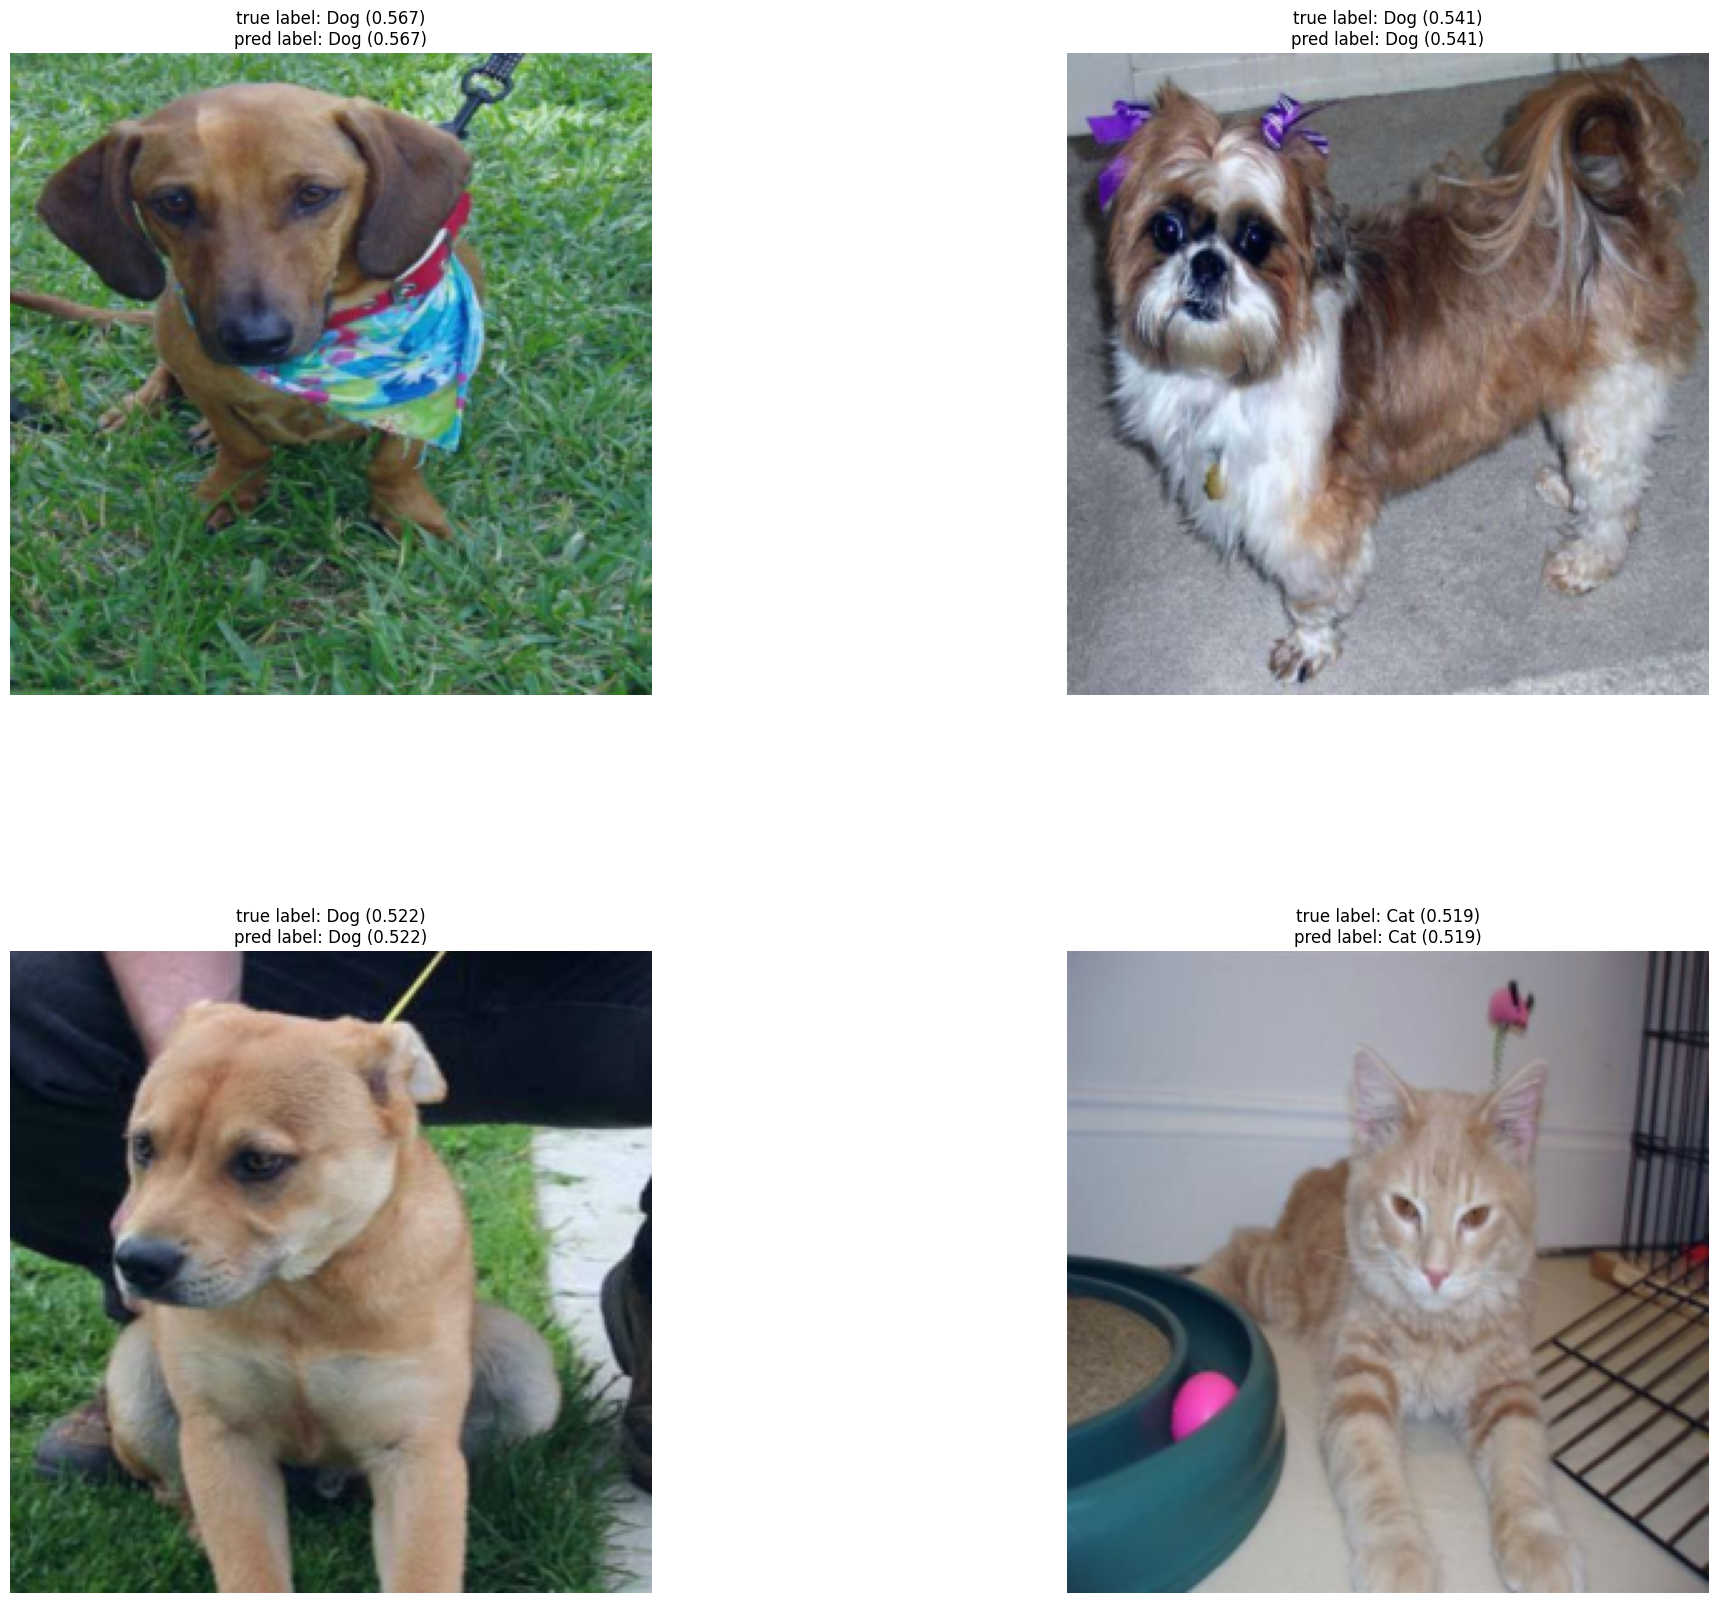

In [44]:
classes=test_dataset.classes
N_IMAGES=5
plot_most_correct(correct_examples,classes,N_IMAGES)